In [ ]:
import torch
print("GPU Available:", torch.cuda.is_available())

GPU Available: False


In [ ]:
!pip install snntorch


In [ ]:
import pickle
import snntorch as snn
import snntorch.spikeplot as splt
import snntorch.spikegen as spk
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import time

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Working with dataset_Tau**

In [ ]:
np.random.seed(120)

#load dataset
with open("/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_trg_m1.pkl", "rb") as f:
    data = pickle.load(f)

#split data into test and train
indexes = np.random.permutation(len(data))
train_size = int(0.8 * len(data))
train_indexes = indexes[:train_size]
test_indexes = indexes[train_size:]

train_data = [data[i] for i in train_indexes]
test_data = [data[i] for i in test_indexes]

print(f"training data size {len(train_data)}")
print(f"test data size {len(test_data)}")


#create CustomDataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.y = []
        self.x = []
        self.labels = []
        self.tau = []
        self.min_dis=[]
        self.min_delay = []
        self.beta0_mag = []
        self.betac_mag_all =[]

        #process each sample
        for sample in data:
            y = sample[0]
            x = sample[1]
            label = sample[2]
            tau = sample[3]
            min_dis = sample[4]
            min_delay= sample[5]
            beta0_mag = sample[6]
            betac_mag_all = sample[7]

            self.y.append(y)
            self.x.append(x)
            self.labels.append(label)
            self.tau.append(tau)
            self.min_dis.append(min_dis)
            self.min_delay.append(min_delay)
            self.beta0_mag.append(beta0_mag)
            self.betac_mag_all.append(betac_mag_all)

        self.y = torch.tensor(self.y, dtype = torch.float32)
        self.x = torch.tensor(self.x, dtype= torch.float32)
        self.labels = torch.tensor(self.labels, dtype= torch.long)
        self.tau = torch.tensor(self.tau, dtype= torch.float32)
        self.min_dis = torch.tensor(self.min_dis, dtype= torch.float32)
        self.min_delay = torch.tensor(self.min_delay, dtype= torch.float32)
        self.beta0_mag = torch.tensor(self.beta0_mag, dtype= torch.float32)
        self.betac_mag_all = torch.tensor(self.betac_mag_all, dtype= torch.float32)

    def __len__(self):
        return(len(self.x))

    def __getitem__(self, index):
        return self.y[index], self.x[index], self.labels[index], self.tau[index], self.min_dis[index], self.min_delay[index], self.beta0_mag[index], self.betac_mag_all[index]

#create train and test dataset
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

#create dataloader
train_loader = DataLoader(train_dataset, batch_size=128 , shuffle=True, drop_last= True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle= True, drop_last= True)


import pandas as pd
print("Class distribution in the original training dataset:", pd.Series(train_dataset.labels).value_counts())
print("Class distribution in the original testing dataset:", pd.Series(test_dataset.labels).value_counts())

for y, x, v, tau, min_dis, min_delay, beta0_mag, betac_mag_all in train_loader:
    print(f"Batch y shape: {y.shape}")
    print(f"Batch x shape: {x.shape}")
    print(f"Batch labels shape: {v.shape}")
    print(f"Batch tau shape: {tau.shape}")
    print(f"Batch min_dis shape: {min_dis.shape}")
    print(f"Batch min-delay shape: {min_delay.shape}")
    print(f"Batch beta0_mag shape: {beta0_mag.shape}")
    print(f"Batch betac_mag_all shape: {betac_mag_all.shape}")
    break  # Just check the first batch


training data size 80000
test data size 20000


<ipython-input-7-cb788d4ba7df>:52: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.y = torch.tensor(self.y, dtype = torch.float32)


Class distribution in the original training dataset: 1    40049
0    39951
Name: count, dtype: int64
Class distribution in the original testing dataset: 1    10059
0     9941
Name: count, dtype: int64
Batch y shape: torch.Size([128, 80, 16])
Batch x shape: torch.Size([128, 80, 16])
Batch labels shape: torch.Size([128])
Batch tau shape: torch.Size([128])
Batch min_dis shape: torch.Size([128])
Batch min-delay shape: torch.Size([128])
Batch beta0_mag shape: torch.Size([128, 1])
Batch betac_mag_all shape: torch.Size([128, 5])


In [ ]:
from snntorch import surrogate

#layer parameters
Ny=32
Nx=32
num_inputs = 16
num_hidden = 256
num_output = 1
num_steps = 80
beta = 0.95
batch_size = 128
dtype = torch.float

#define network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function

        # initialize additional layers for y and x inputs
        self.fc_y = nn.Linear(num_inputs, Ny)
        self.lif_y = snn.Leaky(beta = beta)
        self.fc_x = nn.Linear(num_inputs, Nx)
        self.lif_x = snn.Leaky(beta = beta)

        # initialize SNN layers
        self.fc1 = nn.Linear(Ny + Nx, num_hidden)
        self.lif1 = snn.Leaky(beta = beta)

        # Classification Branch v
        self.fc2 = nn.Linear(num_hidden, num_output)
        self.lif2 = snn.Leaky(beta = beta)

        # Regression Branch τ
        beta_out = torch.rand(1) # randomly initialize decay rate for output neuron
        self.fc_reg = nn.Linear(num_hidden, num_output)
        self.li_out = snn.Leaky(beta=beta, threshold=1.0, learn_beta=True, spike_grad=spike_grad, reset_mechanism="none") #Note the reset mechanism is disabled and we will disregard output spikes.

        # No activation function for τ prediction


    def forward(self, y, x):

        # initialize hidden states at t=0
        mem_y = self.lif_y.init_leaky()
        mem_x = self.lif_x.init_leaky()
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem_reg = self.li_out.init_leaky()

        mem2_rec = []
        spk2_rec = []
        tau_rec = []

        for step in range(num_steps):                         #Loop over 80 time steps
            cur_y = self.fc_y(y[step])
            spk_y, mem_y = self.lif_y(cur_y, mem_y)
            cur_x = self.fc_x(x[step])
            spk_x, mem_x = self.lif_x(cur_x, mem_x)

            combined_input = torch.cat((spk_y, spk_x), dim=1) #Shape:[batch_size:128, Ny + Nx:64]

            cur1 = self.fc1(combined_input)
            spk1, mem1 = self.lif1(cur1, mem1)                #torch.Size([128, 256])

            # Classification branch
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)                #torch.Size([128, 1])
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

            # Regression branch
            cur_reg = self.fc_reg(spk1)
            _, mem_reg = self.li_out(cur_reg, mem_reg)
            tau_rec.append(mem_reg)

        return (torch.stack(spk2_rec, dim=0),
                torch.stack(mem2_rec, dim=0),
                torch.stack(tau_rec, dim=0)) #[num_steps:80, batch_size:128, 1]

# Load the network onto CUDA if available
net = Net().to(device)


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def calculate_metrics(y_true, y_pred_probs, threshold= num_steps / 2):
    # Convert probabilities to binary predictions
    y_pred = (y_pred_probs > threshold).float()

    # Confusion Matrix
    cm = confusion_matrix(y_true.cpu(), y_pred.cpu())
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Precision, Recall, F1
    precision = precision_score(y_true.cpu(), y_pred.cpu())
    recall = recall_score(y_true.cpu(), y_pred.cpu())
    f1 = f1_score(y_true.cpu(), y_pred.cpu())

    # ROC-AUC Score
    auc = roc_auc_score(y_true.cpu(), y_pred_probs.cpu())

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC Score: {auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true.cpu(), y_pred_probs.cpu())
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()


def print_batch_accuracy(spk_pred, v_target, tau_pred, tau_target, train=False):

    # Compute Classification Accuracy
    pred = (spk_pred.sum(dim=0) > num_steps / 2).float()
    class_acc = (pred == v_target).float().mean().item()

    # Compute Regression Errors
    tau_output = tau_pred.mean(dim=0)
    tau_output = torch.mul(tau_output, v_target)
    mse = loss_reg(tau_output, tau_target).item() #torch.nn.functional.mse_loss(tau_output, tau_target).item()  # Mean Squared Error
    # mse =0

    # print(f" tau_output:{tau_output[:5]},\r\n targets_tau: {targets_tau[:5]}")
    # if train:
    #     print(f"Train Accuracy: {acc * 100:.2f}% | MAE (τ): {mae:.6f} | MSE (τ): {mse:.6f}")
    # else:
    #     print(f"Test Accuracy: {acc * 100:.2f}% | MAE (τ): {mae:.6f} | MSE (τ): {mse:.6f}")

    return class_acc, mse


Epoch 1/10

Epoch 1/10 - Evaluation Metrics_Testing:


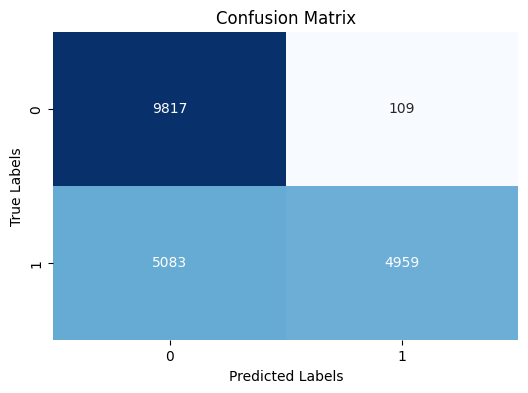

Precision: 0.9785
Recall: 0.4938
F1 Score: 0.6564
ROC-AUC Score: 0.8487


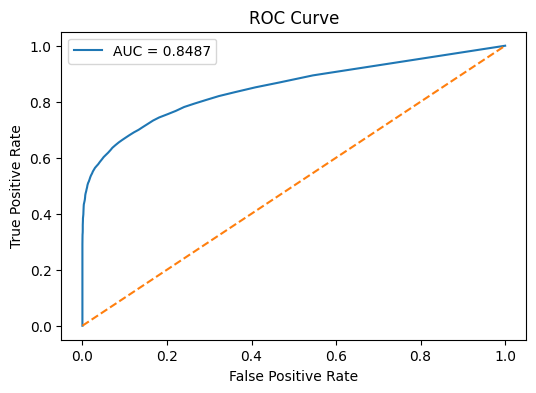

Train Loss avg: 57.9285, 
Test Loss avg: 50.3239
Train Acc: 69.40%, 
Test Acc: 74.00

MSE Train: 4.759263, 
MSE Test: 4.123192
Gap = 0.0460. Resetting stable count.

Epoch 2/10

Epoch 2/10 - Evaluation Metrics_Testing:


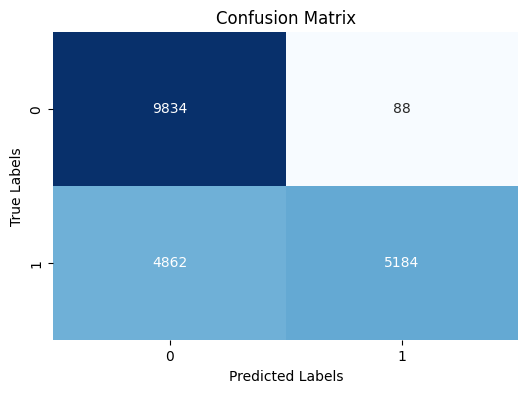

Precision: 0.9833
Recall: 0.5160
F1 Score: 0.6769
ROC-AUC Score: 0.8498


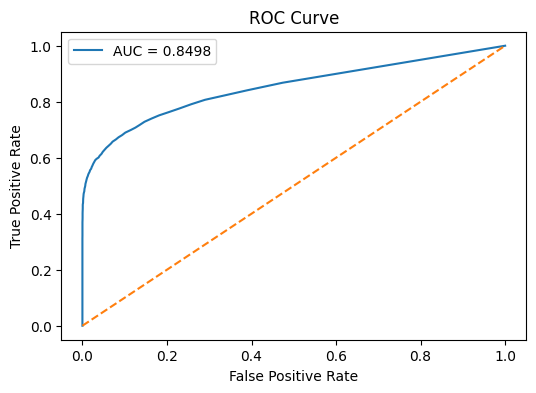

Train Loss avg: 49.4429, 
Test Loss avg: 48.0836
Train Acc: 75.03%, 
Test Acc: 75.21

MSE Train: 4.205858, 
MSE Test: 4.134035
Gap = 0.0018. Resetting stable count.

Epoch 3/10

Epoch 3/10 - Evaluation Metrics_Testing:


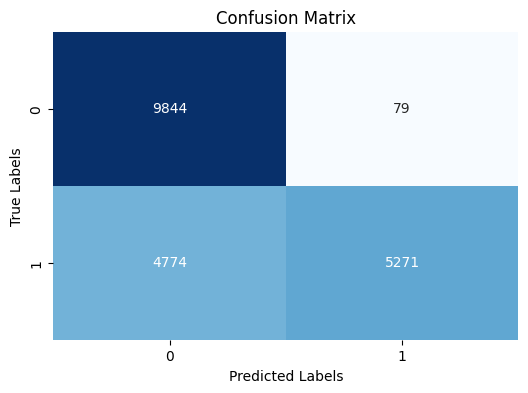

Precision: 0.9852
Recall: 0.5247
F1 Score: 0.6848
ROC-AUC Score: 0.8517


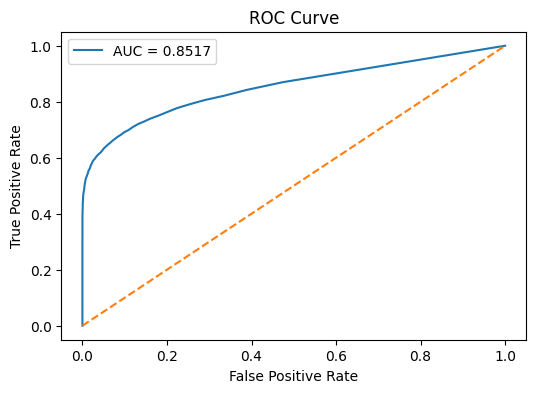

Train Loss avg: 48.3826, 
Test Loss avg: 47.1382
Train Acc: 75.73%, 
Test Acc: 75.70

MSE Train: 4.176292, 
MSE Test: 4.178536
✅ Accuracy converged. Gap = 0.0004. Stable count = 1

Epoch 4/10

Epoch 4/10 - Evaluation Metrics_Testing:


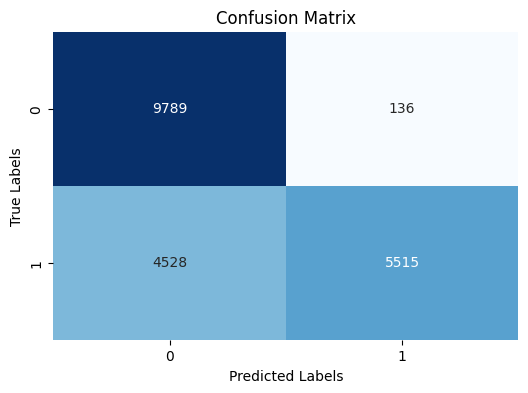

Precision: 0.9759
Recall: 0.5491
F1 Score: 0.7028
ROC-AUC Score: 0.8546


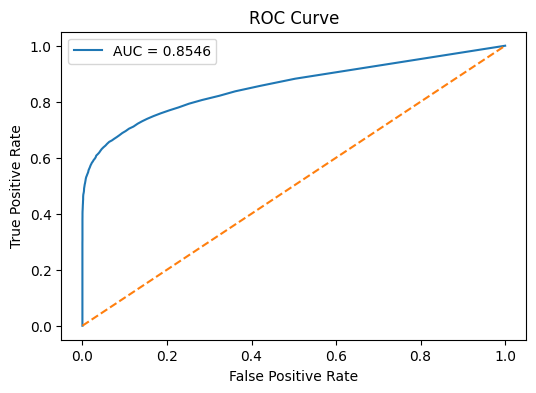

Train Loss avg: 47.5780, 
Test Loss avg: 46.9859
Train Acc: 76.05%, 
Test Acc: 76.64

MSE Train: 4.166188, 
MSE Test: 4.138067
Gap = 0.0059. Resetting stable count.

Epoch 5/10

Epoch 5/10 - Evaluation Metrics_Testing:


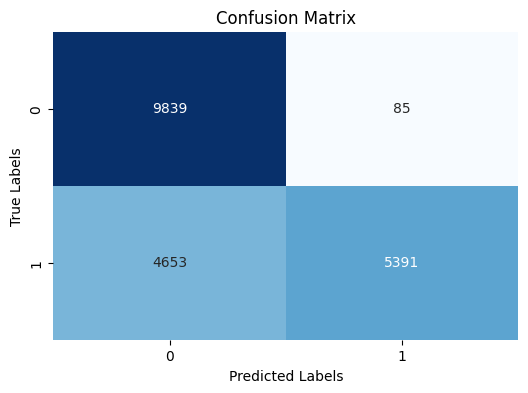

Precision: 0.9845
Recall: 0.5367
F1 Score: 0.6947
ROC-AUC Score: 0.8557


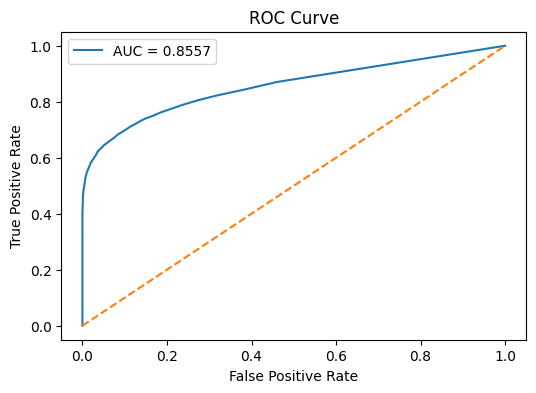

Train Loss avg: 47.2462, 
Test Loss avg: 46.5810
Train Acc: 76.51%, 
Test Acc: 76.27

MSE Train: 4.162595, 
MSE Test: 4.216763
Gap = 0.0024. Resetting stable count.

Epoch 6/10

Epoch 6/10 - Evaluation Metrics_Testing:


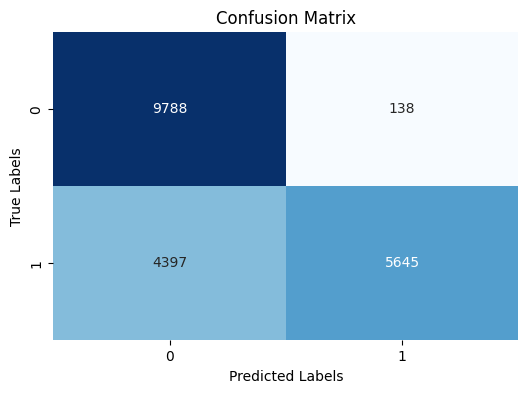

Precision: 0.9761
Recall: 0.5621
F1 Score: 0.7134
ROC-AUC Score: 0.8603


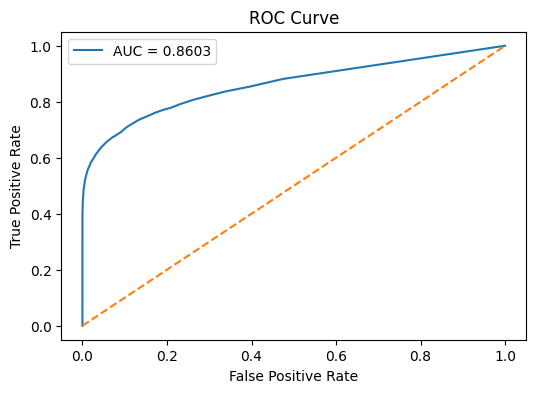

Train Loss avg: 47.0019, 
Test Loss avg: 46.3077
Train Acc: 76.95%, 
Test Acc: 77.29

MSE Train: 4.161353, 
MSE Test: 4.143379
Gap = 0.0033. Resetting stable count.

Epoch 7/10

Epoch 7/10 - Evaluation Metrics_Testing:


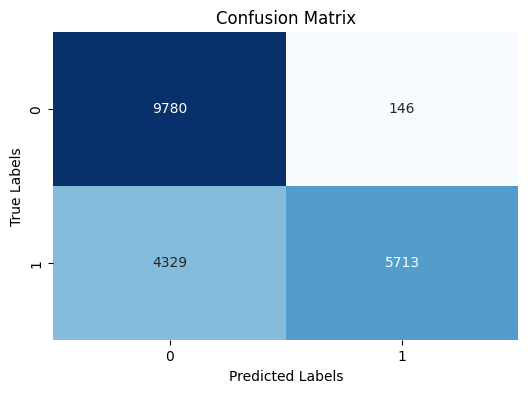

Precision: 0.9751
Recall: 0.5689
F1 Score: 0.7186
ROC-AUC Score: 0.8617


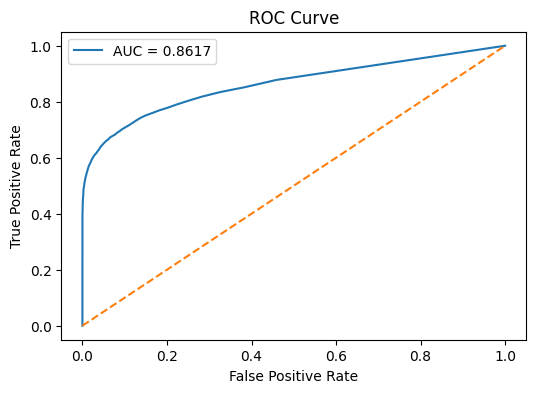

Train Loss avg: 46.7868, 
Test Loss avg: 46.4388
Train Acc: 77.39%, 
Test Acc: 77.59

MSE Train: 4.161522, 
MSE Test: 4.161840
Gap = 0.0020. Resetting stable count.

Epoch 8/10

Epoch 8/10 - Evaluation Metrics_Testing:


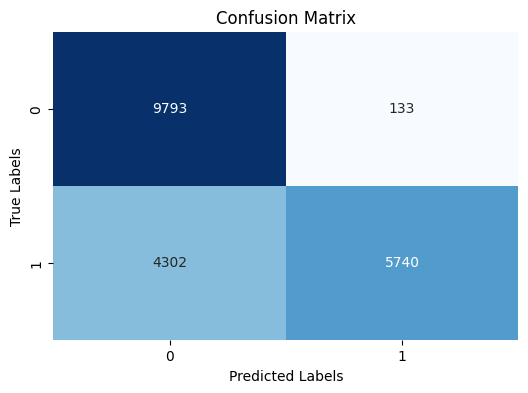

Precision: 0.9774
Recall: 0.5716
F1 Score: 0.7213
ROC-AUC Score: 0.8638


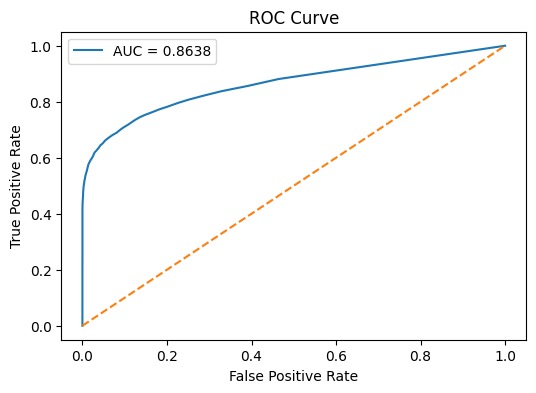

Train Loss avg: 46.5162, 
Test Loss avg: 45.8208
Train Acc: 77.75%, 
Test Acc: 77.79

MSE Train: 4.154911, 
MSE Test: 4.128704
✅ Accuracy converged. Gap = 0.0004. Stable count = 1

Epoch 9/10

Epoch 9/10 - Evaluation Metrics_Testing:


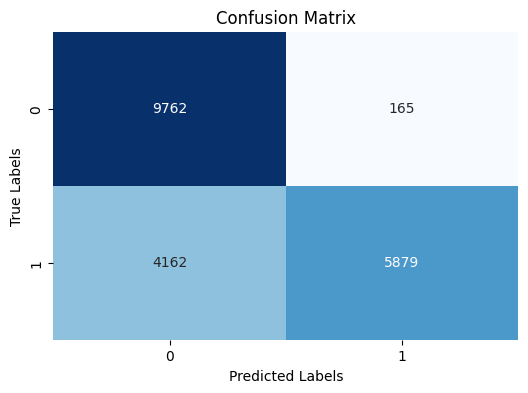

Precision: 0.9727
Recall: 0.5855
F1 Score: 0.7310
ROC-AUC Score: 0.8663


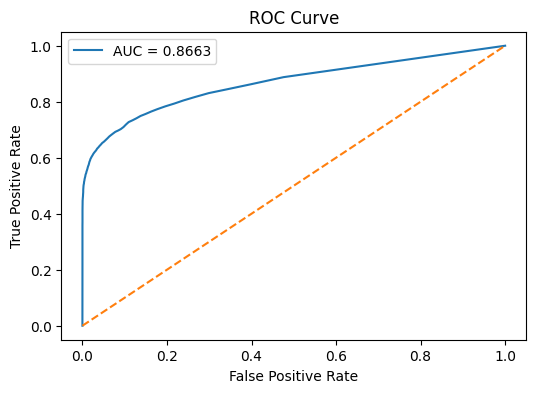

Train Loss avg: 46.3256, 
Test Loss avg: 46.5324
Train Acc: 78.00%, 
Test Acc: 78.33

MSE Train: 4.147433, 
MSE Test: 4.142449
Gap = 0.0033. Resetting stable count.

Epoch 10/10

Epoch 10/10 - Evaluation Metrics_Testing:


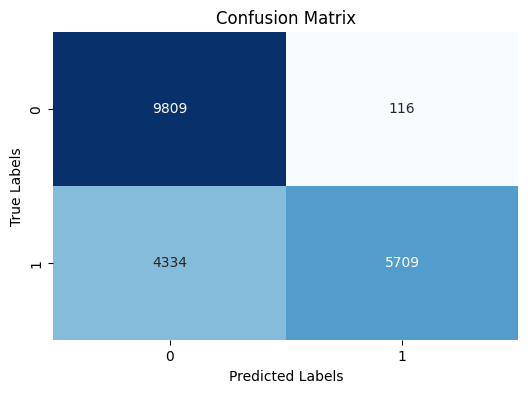

Precision: 0.9801
Recall: 0.5685
F1 Score: 0.7196
ROC-AUC Score: 0.8650


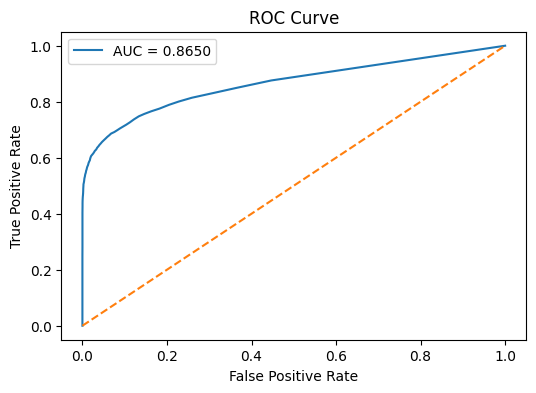

Train Loss avg: 46.0954, 
Test Loss avg: 45.1594
Train Acc: 78.20%, 
Test Acc: 77.71

MSE Train: 4.144176, 
MSE Test: 4.126684
Gap = 0.0049. Resetting stable count.
Total time: 125.29 min.


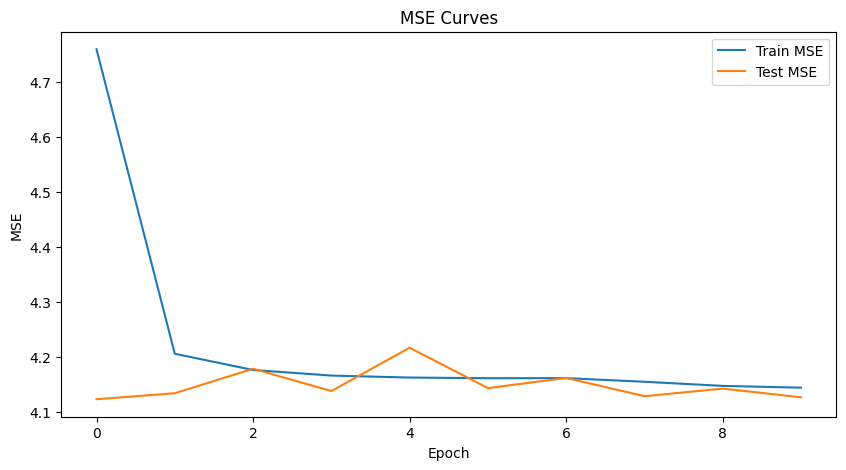

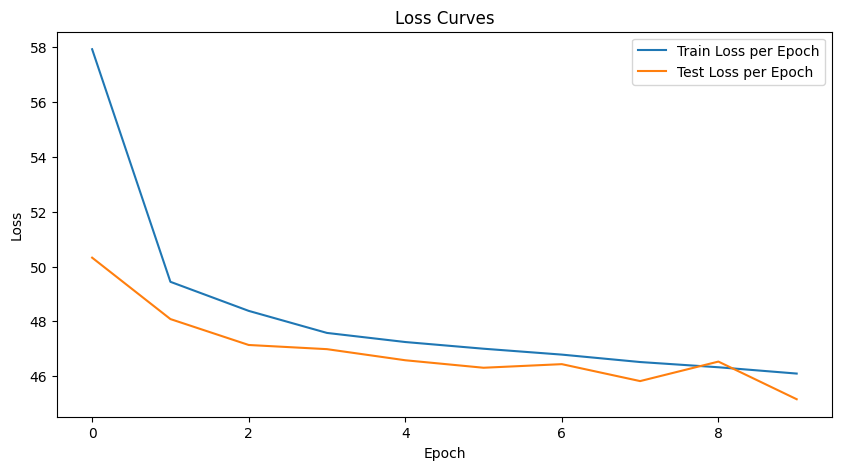

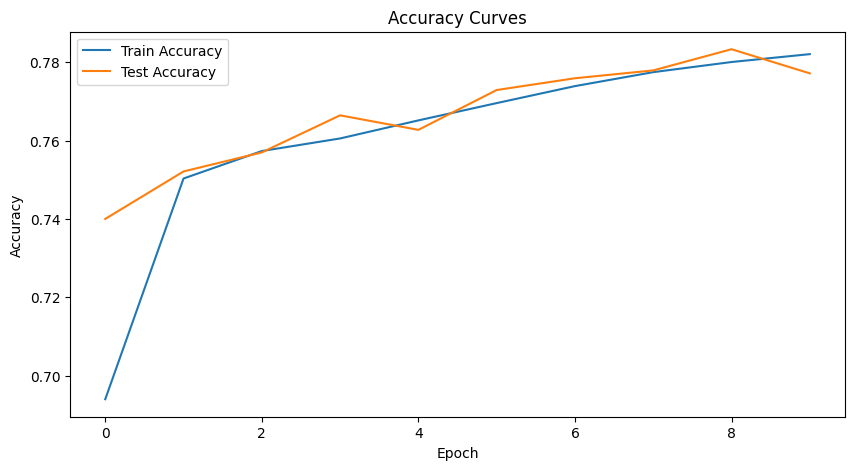

In [ ]:
import time
from snntorch import functional as SF

# Loss functions
loss = nn.BCEWithLogitsLoss()
loss_reg = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999), weight_decay=1e-4)

# Hyperparameters
tau_scale = 1e9
num_epochs = 0
num_steps = 80

# Early stopping based on test accuracy
# waitNo = 5                   # Wait this many epochs for improvement
# min_delta_acc = 1e-4         # Minimum increase in accuracy to be considered improvement
# best_acc = 0.0               # Best accuracy seen so far
# no_improve_count = 0         # Count of epochs without improvement
max_epochs = 10             # Safety cap


best_gap = float("inf")
no_change_count = 0
gap_threshold = 0.001  # acceptable diff between train and test accuracy
stability_epochs = 5



epoch_train_acc = []
epoch_test_acc = []
epoch_train_loss = []
epoch_test_loss = []
epoch_train_mse = []
epoch_test_mse = []

# TRAIN--------------------------------
def train_model(train_loader):
    net.train()
    loss_hist = []
    mse_list = []
    # all_preds = []
    # all_targets = []
    train_acc_hist = []


    train_batch = iter(train_loader)
    for y, x, v, tau, distance, delay, b0, bc in train_batch:
        y = y.to(device).permute(1, 0, 2)
        x = x.to(device).permute(1, 0, 2)
        target_v = v.to(device).float().unsqueeze(1)
        target_tau = (tau.to(device) * tau_scale).float().unsqueeze(1)

        # Forward Pass
        spk_class, mem_class, tau_pre = net(y, x)  #mem_rec.shape torch.Size([80, 128, 1])

        # Classification Loss
        loss_class = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_class += loss(mem_class[step], target_v)

        # Regression Loss
        tau_output = tau_pre.mean(dim=0)
        mask = target_v.bool().squeeze(1)  # Mask for v == 1
        if mask.any():
            tau_pred_masked = tau_output[mask]
            tau_target_masked = target_tau[mask]
            loss_reg_val = loss_reg(tau_pred_masked, tau_target_masked)
        else:
            loss_reg_val = torch.tensor(0.0, device=device)

        # Total Loss
        total_loss = loss_class + loss_reg_val
        loss_hist.append(total_loss.item())

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # Metrics
        train_acc, mse = print_batch_accuracy(spk_class, target_v, tau_pre, target_tau, train=True)
        train_acc_hist.append(train_acc)
        mse_list.append(mse)

    avg_train_loss = sum(loss_hist) / len(loss_hist)
    avg_train_acc = sum(train_acc_hist) / len(train_acc_hist)
    avg_train_mse = sum(mse_list) / len(mse_list)

    return avg_train_loss, avg_train_acc, avg_train_mse


# TEST------------------------------------------------------
def test_model(test_loader):
    net.eval()
    test_loss_hist = []
    test_mse_list = []
    all_preds = []
    all_targets = []
    test_acc_hist = []


    with torch.no_grad():

        test_batch = iter(test_loader)
        for y, x, v, tau, distance, delay, b0, bc in test_batch:
            y = y.to(device).permute(1, 0, 2)
            x = x.to(device).permute(1, 0, 2)
            target_v = v.to(device).float().unsqueeze(1)
            target_tau = (tau.to(device) * tau_scale).float().unsqueeze(1)

            # Forward Pass
            spk_class, mem_class, tau_pre = net(y, x)

            # Classification Loss
            test_loss_class = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss_class += loss(mem_class[step], target_v)

            # Regression Loss
            test_tau_output = tau_pre.mean(dim=0)
            mask = target_v.bool().squeeze(1)  # Mask for v == 1
            if mask.any():
                tau_pred_masked = test_tau_output[mask]
                tau_target_masked = target_tau[mask]
                test_loss_reg = loss_reg(tau_pred_masked, tau_target_masked)
            else:
                test_loss_reg = torch.tensor(0.0, device=device)

            # Total Test Loss
            test_total_loss = test_loss_class + test_loss_reg
            test_loss_hist.append(test_total_loss.item())

            # Compute Metrics
            test_acc, test_mse = print_batch_accuracy(spk_class, target_v, tau_pre, target_tau, train=False)
            test_acc_hist.append(test_acc)
            test_mse_list.append(test_mse)

            # Collect Predictions
            class_output = spk_class.sum(dim=0)
            all_preds.extend(class_output.squeeze().cpu().numpy())
            all_targets.extend(target_v.squeeze().cpu().numpy())

    # Compute Overall Test Metrics
    all_preds = torch.tensor(all_preds)
    all_targets = torch.tensor(all_targets)
    print(f"\nEpoch {num_epochs+1}/{max_epochs} - Evaluation Metrics_Testing:")
    calculate_metrics(all_targets, all_preds)

    avg_test_loss = sum(test_loss_hist) / len(test_loss_hist)
    avg_test_acc = sum(test_acc_hist) / len(test_acc_hist)
    avg_test_mse = sum(test_mse_list) / len(test_mse_list)

    return avg_test_loss, avg_test_acc, avg_test_mse


# MAIN TRAINING & TESTING LOOP-----------------------------

start_time = time.time()

while num_epochs < max_epochs:
    print(f"\nEpoch {num_epochs + 1}/{max_epochs}")

    # Train the Model
    avg_train_loss, avg_train_acc, avg_train_mse = train_model(train_loader)
    epoch_train_loss.append(avg_train_loss)
    epoch_train_acc.append(avg_train_acc)
    epoch_train_mse.append(avg_train_mse)


    # Test the Model
    avg_test_loss, avg_test_acc, avg_test_mse  = test_model(test_loader)
    epoch_test_loss.append(avg_test_loss)
    epoch_test_acc.append(avg_test_acc)
    epoch_test_mse.append(avg_test_mse)

    print(f"Train Loss avg: {avg_train_loss:.4f}, \nTest Loss avg: {avg_test_loss:.4f}")
    print(f"Train Acc: {avg_train_acc * 100:.2f}%, \nTest Acc: {avg_test_acc * 100:.2f}\n")
    print(f"MSE Train: {avg_train_mse:.6f}, \nMSE Test: {avg_test_mse:.6f}")


    # Check for convergence
    acc_gap = abs(avg_train_acc - avg_test_acc)

    if acc_gap < gap_threshold:
        no_change_count += 1
        print(f"✅ Accuracy converged. Gap = {acc_gap:.4f}. Stable count = {no_change_count}")
    else:
        no_change_count = 0
        print(f"Gap = {acc_gap:.4f}. Resetting stable count.")

    if no_change_count >= stability_epochs:
        print("🚨 Early stopping triggered (train/test accuracy converged).")
        num_epochs = max_epochs

    # # Check for accuracy improvement
    # if avg_test_acc - best_acc > min_delta_acc:
    #     best_acc = avg_test_acc
    #     no_improve_count = 0
    #     print(f"acc: {avg_test_acc}, best_acc: {best_acc}")
    # else:
    #     no_improve_count += 1
    #     print(f"No accuracy improvement for {no_improve_count} epoch(s).")

    # if no_improve_count >= waitNo:
    #     print("🚨 Early stopping triggered (no accuracy improvement).")
    #     break

    num_epochs += 1


# Plot--------------------------------------------------------
end_time = time.time()
print(f"Total time: {(end_time - start_time) / 60:.2f} min.")

# Plot MSE Loss
plt.figure(figsize=(10, 5))
plt.plot(range(len(epoch_train_mse)), epoch_train_mse, label="Train MSE")
plt.plot(range(len(epoch_test_mse)), epoch_test_mse, label="Test MSE")
plt.title("MSE Curves")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

# Plot Train & Test Loss per Epoch
plt.figure(figsize=(10, 5))
plt.plot(range(len(epoch_train_loss)), epoch_train_loss, label="Train Loss per Epoch")
plt.plot(range(len(epoch_test_loss)), epoch_test_loss, label="Test Loss per Epoch")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label="Train Accuracy")
plt.plot(range(len(epoch_test_acc)), epoch_test_acc, label="Test Accuracy")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()




**Total test-------------**

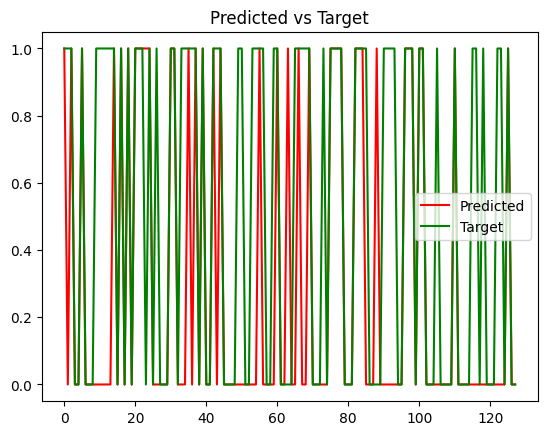

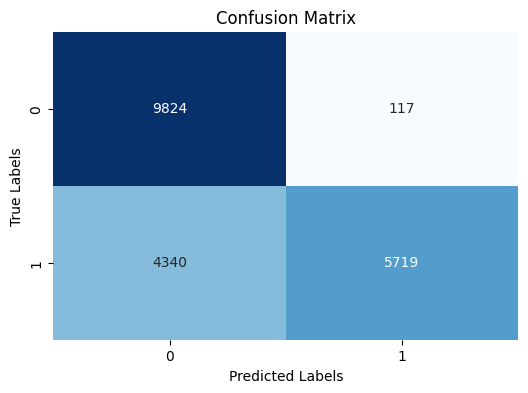

Precision: 0.9800
Recall: 0.5685
F1 Score: 0.7196
ROC-AUC Score: 0.8650


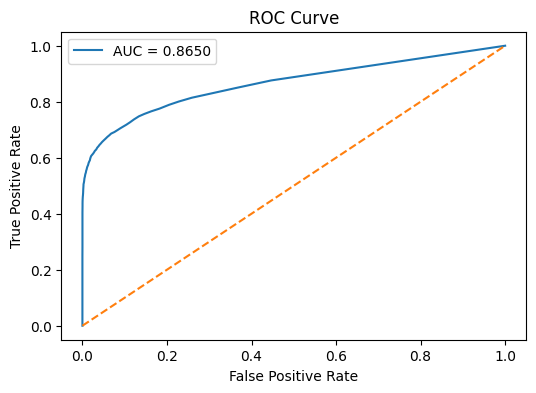

Total size: 20000, Correct_Prediction: 15543.0
Test Set Accuracy: 77.715%, acc : 77.63%
Average Test Loss: 45.2371


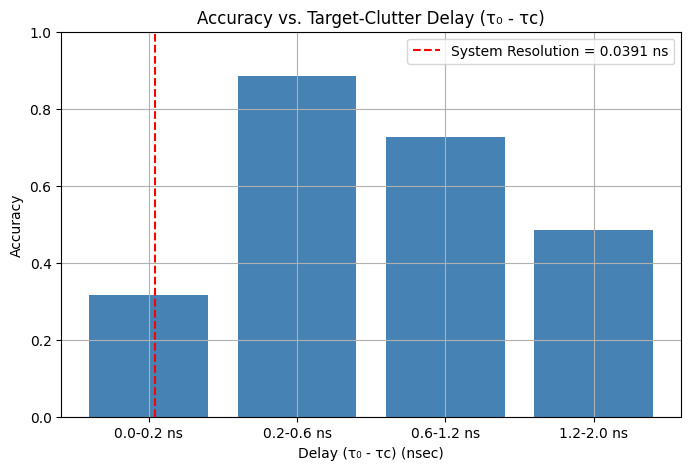

Bin 0-5 ns: Samples = 1752, Accuracy = 0.316
Bin 5-15 ns: Samples = 13522, Accuracy = 0.884
Bin 15-30 ns: Samples = 3063, Accuracy = 0.726
Bin 30-50 ns: Samples = 1663, Accuracy = 0.484
Bin 50-100 ns: Samples = 0, Accuracy = nan


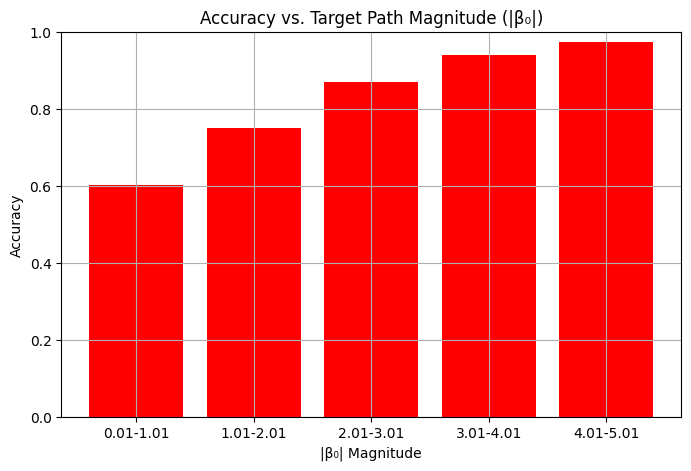

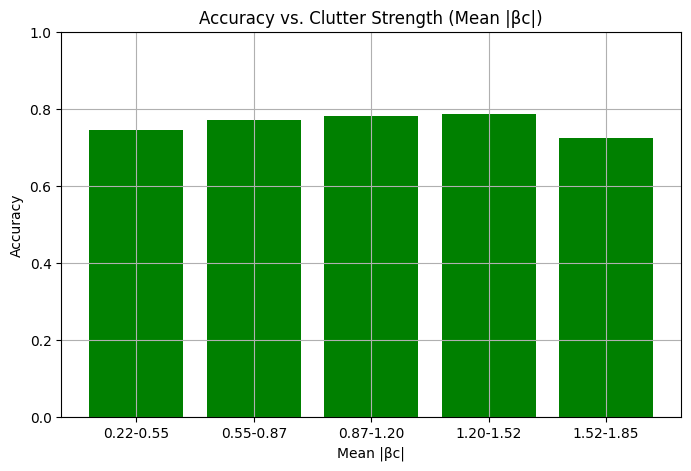

In [ ]:
import numpy as np
config_resolution = 3.90625e-11  # sec

# Define bin ranges
bins = [(0, 5), (5, 15), (15, 30), (30, 50), (50, 100)]


def compute_accuracy_in_bins(preds, true_vs, min_dists, bins):
    acc_by_bin = []
    bin_labels = []

    for (low, high) in bins:
        bin_indices = [i for i, d in enumerate(min_dists) if low <= d < high]

        if not bin_indices:
            acc_by_bin.append(np.nan)
            bin_labels.append((low, high))
            continue

        preds_bin = [preds[i] for i in bin_indices]
        targets_bin = [true_vs[i] for i in bin_indices]

        acc = np.mean(np.array(preds_bin) == np.array(targets_bin))
        acc_by_bin.append(acc)
        bin_labels.append((low, high))

    return bin_labels, acc_by_bin




#Test the model with dataset5_Tau ------------------------------
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, drop_last=False)
loss = nn.BCEWithLogitsLoss()
loss_reg = nn.MSELoss()
total = 0
correct = 0
test_loss_class=0
i=0
all_preds=[]
all_targets=[]
accList=[]
test_loss_hist=[]
test_mse_list = []

min_dists = []
all_tau_preds = []
all_tau_targets = []


all_beta0 = []
all_betac_means = []


with torch.no_grad():
  net.eval()
  for y_t, x_t, v, tau, distance, delay, b0, bc in test_loader:
    y_t = y_t.to(device).permute(1, 0, 2)
    x_t = x_t.to(device).permute(1, 0, 2)
    target_v = v.to(device).float().unsqueeze(1)
    target_tau = (tau.to(device) * tau_scale).float().unsqueeze(1)
    min_dists.extend(distance.to(device).cpu().numpy())


    all_beta0.extend(np.abs(b0.cpu().numpy()))
    all_betac_means.extend(np.mean(np.abs(bc.cpu().numpy()), axis=1))


    # forward pass
    test_spk, test_mem, test_tau = net(y_t, x_t)

    # Classification loss
    test_loss_class = torch.zeros((1), dtype=dtype, device=device)
    for step in range(num_steps):
      test_loss_class += loss(test_mem[step], target_v)


    # Regression Loss
    test_tau_output = test_tau.mean(dim=0)
    mask = target_v.bool().squeeze(1)  # Mask for v == 1
    if mask.any():
        tau_pred_masked = test_tau_output[mask]
        tau_target_masked = target_tau[mask]
        test_loss_reg = loss_reg(tau_pred_masked, tau_target_masked)

        all_tau_preds.extend(tau_pred_masked.detach().cpu().numpy())
        all_tau_targets.extend(tau_target_masked.detach().cpu().numpy())
    else:
        test_loss_reg = torch.tensor(0.0, device=device)

    # Total Test Loss
    test_total_loss = test_loss_class + test_loss_reg
    test_loss_hist.append(test_total_loss.item())


    # Calculate accuracy
    predicted = (test_spk.sum(dim=0) > num_steps / 2).float()
    acc = (predicted == target_v).float().mean().item()
    correct += (predicted == target_v).float().sum().item()
    total += target_v.size(0)

    classOutput = test_spk.sum(dim=0)
    all_preds.extend(classOutput.squeeze().cpu().numpy())
    all_targets.extend(target_v.squeeze().cpu().numpy())

    accList.append(acc)

    i+=1
    if i == 1:
      plt.plot(predicted.cpu(), label='Predicted', color='red')
      plt.plot(target_v.cpu(), label='Target', color='green')
      plt.title('Predicted vs Target')
      plt.legend()
      plt.show()

# Compute Overall Test Metrics
all_preds = torch.tensor(all_preds)
all_targets = torch.tensor(all_targets)
calculate_metrics(all_targets, all_preds)

print(f"Total size: {total}, Correct_Prediction: {correct}")
print(f"Test Set Accuracy: {100 * correct / total}%, acc : {(sum(accList)/ len(accList)) * 100:.2f}%")
print(f"Average Test Loss: {sum(test_loss_hist) / len(test_loss_hist):.4f}")


# Compute Accuracy per delay-----------------------------
bin_preds = (all_preds > num_steps / 2).float().numpy()
bin_true = all_targets.numpy()
# Compute accuracy in bins
bin_labels, accs = compute_accuracy_in_bins(bin_preds, bin_true, min_dists, bins)
delay_bin_labels = [f"{low * config_resolution * 1e9:.1f}-{high * config_resolution * 1e9:.1f} ns" for (low, high) in bin_labels]

# Plot the result
plt.figure(figsize=(8, 5))
plt.bar(delay_bin_labels, accs, color='steelblue')
plt.axvline(x = config_resolution * 1e9, linestyle='--',color='red', label=f"System Resolution = {config_resolution * 1e9:.4f} ns")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Delay (τ₀ - τc) (nsec)")
plt.title("Accuracy vs. Target-Clutter Delay (τ₀ - τc)")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

for label, acc in zip(bin_labels, accs):
    low, high = label
    count = sum(1 for d in min_dists if float(low) <= d < float(high))
    print(f"Bin {low}-{high} ns: Samples = {count}, Accuracy = {acc:.3f}")


num_bins = 5
all_beta0_flat = np.array(all_beta0).flatten()
beta0_min = round(float(np.min(all_beta0_flat)), 2)
beta0_max = round(float(np.max(all_beta0_flat)), 2)
bin_edges = np.linspace(round(beta0_min, 2), round(beta0_max, 2), num_bins + 1)
beta0_bins = [(bin_edges[i], bin_edges[i+1]) for i in range(num_bins)]

# beta_bins = [(0, 0.5), (0.5, 1), (1, 2), (2, 3), (3, 5)]
labels_beta0, accs_beta0 = compute_accuracy_in_bins(bin_preds, bin_true, all_beta0, beta0_bins)
label_strs = [f"{low:.2f}-{high:.2f}" for (low, high) in labels_beta0]

plt.figure(figsize=(8, 5))
plt.bar(label_strs, accs_beta0, color='red')
plt.ylabel("Accuracy")
plt.xlabel("|β₀| Magnitude")
plt.title("Accuracy vs. Target Path Magnitude (|β₀|)")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

all_betac_means_flat = np.array(all_betac_means).flatten()
betac_min = round(float(np.min(all_betac_means_flat)), 2)
betac_max = round(float(np.max(all_betac_means_flat)), 2)
bin_edges = np.linspace(betac_min, betac_max, num_bins + 1)
betac_bins = [(bin_edges[i], bin_edges[i+1]) for i in range(num_bins)]
labels_betac, accs_betac = compute_accuracy_in_bins(bin_preds, bin_true, all_betac_means, betac_bins)
label_strs = [f"{low:.2f}-{high:.2f}" for (low, high) in labels_betac]

plt.figure(figsize=(8, 5))
plt.bar(label_strs, accs_betac, color='green')
plt.ylabel("Accuracy")
plt.xlabel("Mean |βc|")
plt.title("Accuracy vs. Clutter Strength (Mean |βc|)")
plt.ylim(0, 1)
plt.grid(True)
plt.show()






In [ ]:
import torch

# Compute mean and standard deviation of your dataset
x_mean = train_dataset.x.mean(dim=0)
x_std = train_dataset.x.std(dim=0)

y_mean = train_dataset.y.mean(dim=0)
y_std = train_dataset.y.std(dim=0)

# print(f"{x_mean.shape}, X Mean: {x_mean}")
# print(f"{x_std.shape}X Std Dev: {x_std}")
# print(f"{y_mean.shape}Y Mean: {y_mean}")
# print(f"{y_std.shape}Y Std Dev: {y_std}")


**Save the model weights for dataset5**

In [ ]:
import torch

torch.save(net.state_dict(), '/content/drive/MyDrive/Colab Notebooks/SNN/Model/clusternew_dt_trg_m1.pkl.pth')


**Load the trained model**

In [ ]:
mynet = Net()
mynet.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/SNN/Model/model_weights_dataset5.pth'))
mynet.eval()

**Final Result**

                               Dataset  Mean(|β₀|)  Mean(|βc|)  \
0   m_t=0   var_t=2,   m_c=0   var_c=1       1.255       0.886   
1   m_t=0   var_t=2,   m_c=0   var_c=5       1.249       1.982   
2  m_t=0   var_t=2,   m_c=0   var_c=10       1.258       2.800   
3   m_t=0   var_t=2,   m_c=1   var_c=1       1.255       1.607   
4   m_t=0   var_t=2,   m_c=2   var_c=1       1.249       2.920   
5   m_t=0   var_t=2,   m_c=3   var_c=1       1.258       4.302   

   Mean Delay (ns)  Test Accuracy (%)  
0            1.497              73.79  
1            1.496              67.45  
2            1.499              63.93  
3            1.623              66.90  
4            1.635              61.34  
5            1.623              57.51  


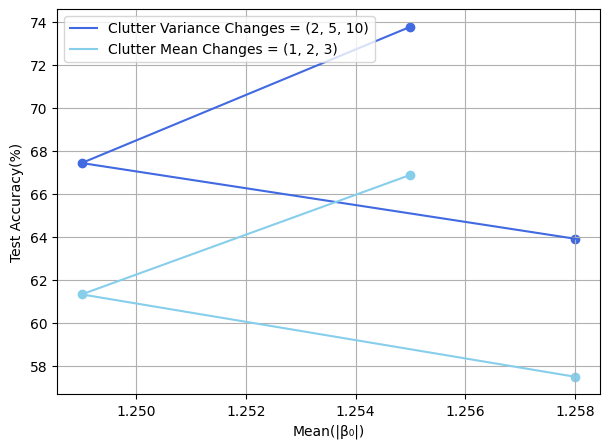

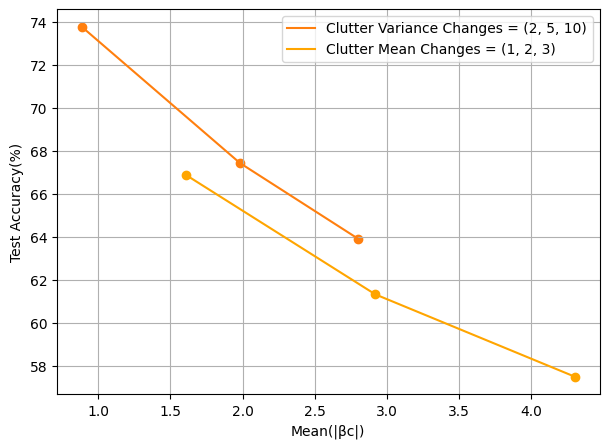

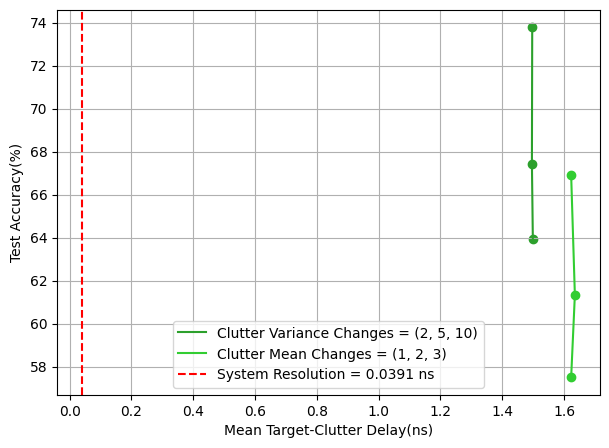

In [10]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

system_resolution = 3.90625e-11  # seconds
system_resolution_ns = round(system_resolution * 1e9, 4)

dataset_names = [
    "m_t=0   var_t=2,   m_c=0   var_c=1",
    "m_t=0   var_t=2,   m_c=0   var_c=5",
    "m_t=0   var_t=2,   m_c=0   var_c=10",
    "m_t=0   var_t=2,   m_c=1   var_c=1",
    "m_t=0   var_t=2,   m_c=2   var_c=1",
    "m_t=0   var_t=2,   m_c=3   var_c=1"
]

dataset_files = [
    "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/vt=2-vc=1/new_clt_vc=1_mc=0.pkl",
    "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/vt=2-vc=1/new_clt_v5_mc=0.pkl",
    "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/vt=2-vc=1/new_clt_v10_mc=0.pkl",
     "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/vt=2-vc=1/new_clt_mc1.pkl",
    "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/vt=2-vc=1/new_clt_mc2.pkl",
    "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/vt=2-vc=1/new_clt_mc3.pkl"
]

# Prepare lists for summary
summary_data = []

for idx, file in enumerate(dataset_files):
    with open(file, 'rb') as f:
        data = pickle.load(f)






    accs = [73.79, 67.45, 63.93, 66.90, 61.34, 57.51]
    delays = []
    b0_mags_all = []
    bc_mags_all = []

    for (yl2, xl2, v, tau, min_dist, min_delay_sec, b0_mag, bc_mags) in data:
        delays.append(min_delay_sec)
        if isinstance(b0_mag, np.ndarray):
            b0_mags_all.extend(b0_mag.flatten())
        elif b0_mag is not None:
            b0_mags_all.append(b0_mag)

        bc_mags_all.extend(np.abs(bc_mags))

    mean_b0 = np.mean(b0_mags_all)
    mean_bc = np.mean(bc_mags_all)
    mean_delay_ns = np.mean(delays)


    test_accuracy = accs[idx]

    summary_data.append({
        "Dataset": dataset_names[idx],
        "Mean(|β₀|)": round(mean_b0, 3),
        "Mean(|βc|)": round(mean_bc, 3),
        "Mean Delay (ns)": round(mean_delay_ns, 3),
        "Test Accuracy (%)": round(test_accuracy, 2)
    })

# Create DataFrame
df = pd.DataFrame(summary_data)
print(df)

# Plotting Accuracy vs β₀
plt.figure(figsize=(7, 5))
plt.scatter(df["Mean(|β₀|)"][0:3], df["Test Accuracy (%)"][0:3], color='royalblue')
plt.plot(df["Mean(|β₀|)"][0:3], df["Test Accuracy (%)"][0:3], color='royalblue', label=f"Clutter Variance Changes = {2, 5, 10}")
plt.scatter(df["Mean(|β₀|)"][3:], df["Test Accuracy (%)"][3:], color='skyblue')
plt.plot(df["Mean(|β₀|)"][3:], df["Test Accuracy (%)"][3:], color='skyblue', label=f"Clutter Mean Changes = {1, 2, 3}")
plt.xlabel("Mean(|β₀|)")
plt.ylabel("Test Accuracy(%)")
plt.legend()
# plt.title("Accuracy vs. Target Strength (|β₀|)")
plt.grid(True)
plt.show()

# Plotting Accuracy vs βc
plt.figure(figsize=(7, 5))
plt.scatter(df["Mean(|βc|)"][0:3], df["Test Accuracy (%)"][0:3], color='#ff7f0e')
plt.plot(df["Mean(|βc|)"][0:3], df["Test Accuracy (%)"][0:3], color='#ff7f0e', label=f"Clutter Variance Changes = {2, 5, 10}")
plt.scatter(df["Mean(|βc|)"][3:], df["Test Accuracy (%)"][3:], color='orange')
plt.plot(df["Mean(|βc|)"][3:], df["Test Accuracy (%)"][3:], color='orange', label=f"Clutter Mean Changes = {1, 2, 3}")
plt.xlabel("Mean(|βc|)")
plt.ylabel("Test Accuracy(%)")
plt.legend()
# plt.title("Accuracy vs. Clutter Strength (|βc|)")
plt.grid(True)
plt.show()

# Plotting Accuracy vs Delay
plt.figure(figsize=(7, 5))
plt.scatter(df["Mean Delay (ns)"][0:3], df["Test Accuracy (%)"][0:3], color='#2ca02c')
plt.plot(df["Mean Delay (ns)"][0:3], df["Test Accuracy (%)"][0:3], color='#2ca02c', label=f"Clutter Variance Changes = {2, 5, 10}")
plt.scatter(df["Mean Delay (ns)"][3:], df["Test Accuracy (%)"][3:], color='limegreen')
plt.plot(df["Mean Delay (ns)"][3:], df["Test Accuracy (%)"][3:], color='limegreen', label=f"Clutter Mean Changes = {1, 2, 3}")
plt.axvline(system_resolution_ns, color='red', linestyle='--', label=f"System Resolution = {system_resolution_ns} ns")
plt.xlabel("Mean Target-Clutter Delay(ns)")
plt.ylabel("Test Accuracy(%)")
# plt.title("Accuracy vs. Target-Clutter Delay")
plt.legend()
plt.grid(True)
plt.show()


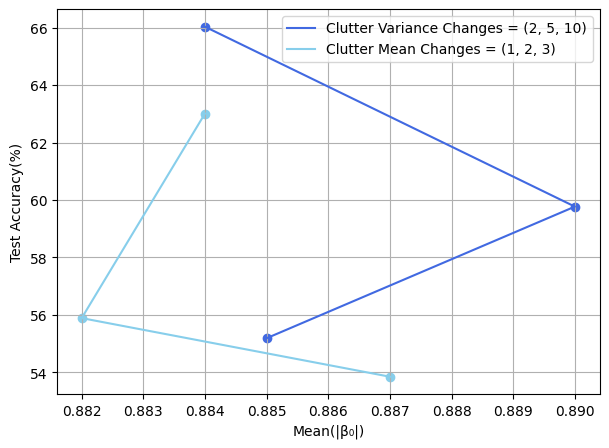

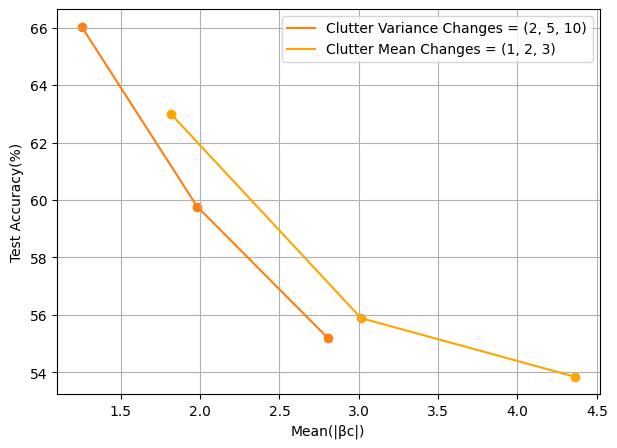

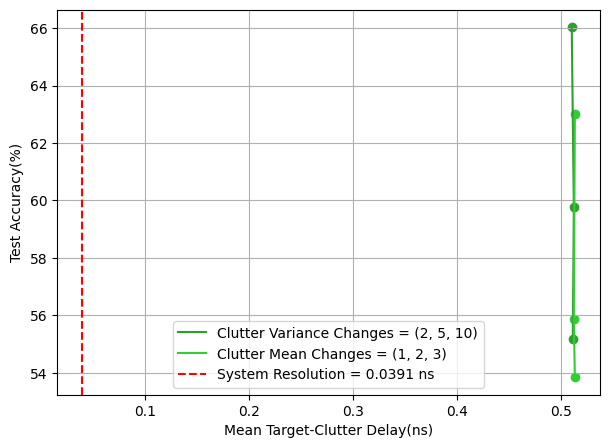

In [37]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

system_resolution = 3.90625e-11  # seconds
system_resolution_ns = round(system_resolution * 1e9, 4)

dataset_names = [
    "m_t=0   var_t=1,   m_c=0   var_c=2",
    "m_t=0   var_t=1,   m_c=0   var_c=5",
    "m_t=0   var_t=1,   m_c=0   var_c=10",
    "m_t=0   var_t=1,   m_c=1   var_c=2",
    "m_t=0   var_t=1,   m_c=2   var_c=2",
    "m_t=0   var_t=1,   m_c=3   var_c=2"
]

dataset_files = [
    "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_clt_v2.pkl",
    "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_clt_v5.pkl",
    "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_clt_v10.pkl",
     "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_clt_m1.pkl",
    "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_clt_m2.pkl",
    "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_clt_m3.pkl"
]

# # Prepare lists for summary
# summary_data = []

# for idx, file in enumerate(dataset_files):
#     with open(file, 'rb') as f:
#         data = pickle.load(f)






#     accs = [66.03, 59.77, 55.19, 63.01, 55.89, 53.85]
#     delays = []
#     b0_mags_all = []
#     bc_mags_all = []

#     for (yl2, xl2, v, tau, min_dist, min_delay_sec, b0_mag, bc_mags) in data:
#         delays.append(min_delay_sec)
#         if isinstance(b0_mag, np.ndarray):
#             b0_mags_all.extend(b0_mag.flatten())
#         elif b0_mag is not None:
#             b0_mags_all.append(b0_mag)

#         bc_mags_all.extend(np.abs(bc_mags))

#     mean_b0 = np.mean(b0_mags_all)
#     mean_bc = np.mean(bc_mags_all)
#     mean_delay_ns = np.mean(delays)


#     test_accuracy = accs[idx]

#     summary_data.append({
#         "Dataset": dataset_names[idx],
#         "Mean(|β₀|)": round(mean_b0, 3),
#         "Mean(|βc|)": round(mean_bc, 3),
#         "Mean Delay (ns)": round(mean_delay_ns, 3),
#         "Test Accuracy (%)": round(test_accuracy, 2)
#     })

# # Create DataFrame
# df = pd.DataFrame(summary_data)
# print(df)

# Plotting Accuracy vs β₀
plt.figure(figsize=(7, 5))
plt.scatter(df["Mean(|β₀|)"][0:3], df["Test Accuracy (%)"][0:3], color='royalblue')
plt.plot(df["Mean(|β₀|)"][0:3], df["Test Accuracy (%)"][0:3], color='royalblue', label=f"Clutter Variance Changes = {2, 5, 10}")
plt.scatter(df["Mean(|β₀|)"][3:], df["Test Accuracy (%)"][3:], color='skyblue')
plt.plot(df["Mean(|β₀|)"][3:], df["Test Accuracy (%)"][3:], color='skyblue', label=f"Clutter Mean Changes = {1, 2, 3}")
plt.xlabel("Mean(|β₀|)")
plt.ylabel("Test Accuracy(%)")
plt.legend()
# plt.title("Accuracy vs. Target Strength (|β₀|)")
plt.grid(True)
plt.show()

# Plotting Accuracy vs βc
plt.figure(figsize=(7, 5))
plt.scatter(df["Mean(|βc|)"][0:3], df["Test Accuracy (%)"][0:3], color='#ff7f0e')
plt.plot(df["Mean(|βc|)"][0:3], df["Test Accuracy (%)"][0:3], color='#ff7f0e', label=f"Clutter Variance Changes = {2, 5, 10}")
plt.scatter(df["Mean(|βc|)"][3:], df["Test Accuracy (%)"][3:], color='orange')
plt.plot(df["Mean(|βc|)"][3:], df["Test Accuracy (%)"][3:], color='orange', label=f"Clutter Mean Changes = {1, 2, 3}")
plt.xlabel("Mean(|βc|)")
plt.ylabel("Test Accuracy(%)")
plt.legend()
# plt.title("Accuracy vs. Clutter Strength (|βc|)")
plt.grid(True)
plt.show()

# Plotting Accuracy vs Delay
plt.figure(figsize=(7, 5))
plt.scatter(df["Mean Delay (ns)"][0:3], df["Test Accuracy (%)"][0:3], color='#2ca02c')
plt.plot(df["Mean Delay (ns)"][0:3], df["Test Accuracy (%)"][0:3], color='#2ca02c', label=f"Clutter Variance Changes = {2, 5, 10}")
plt.scatter(df["Mean Delay (ns)"][3:], df["Test Accuracy (%)"][3:], color='limegreen')
plt.plot(df["Mean Delay (ns)"][3:], df["Test Accuracy (%)"][3:], color='limegreen', label=f"Clutter Mean Changes = {1, 2, 3}")
plt.axvline(system_resolution_ns, color='red', linestyle='--', label=f"System Resolution = {system_resolution_ns} ns")
plt.xlabel("Mean Target-Clutter Delay(ns)")
plt.ylabel("Test Accuracy(%)")
# plt.title("Accuracy vs. Target-Clutter Delay")
plt.legend()
plt.grid(True)
plt.show()


                               Dataset  Mean(|β₀|)  Mean(|βc|)  \
0   m_t=0   var_t=2,   m_c=0   var_c=2       1.249       0.886   
1   m_t=0   var_t=5,   m_c=0   var_c=2       1.985       0.887   
2  m_t=0   var_t=10,   m_c=0   var_c=2       2.803       0.886   
3   m_t=1   var_t=1,   m_c=0   var_c=2       1.812       0.885   
4   m_t=2   var_t=1,   m_c=0   var_c=2       3.016       0.887   
5   m_t=3   var_t=1,   m_c=0   var_c=2       4.365       0.887   

   Mean Delay (ns)  Test Accuracy (%)  
0            0.513              69.75  
1            0.512              77.56  
2            0.512              84.62  
3            0.512              77.63  
4            0.512              90.55  
5            0.513              96.92  


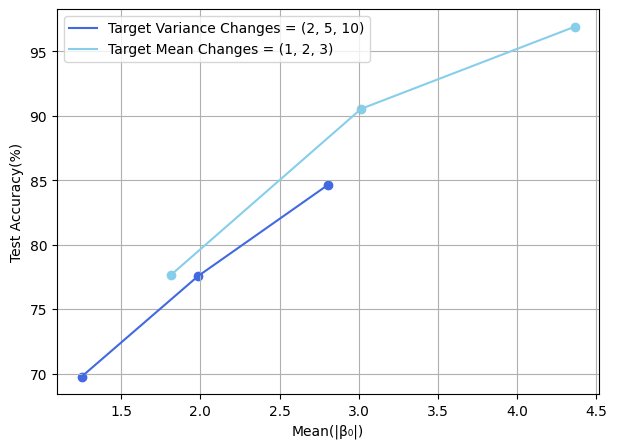

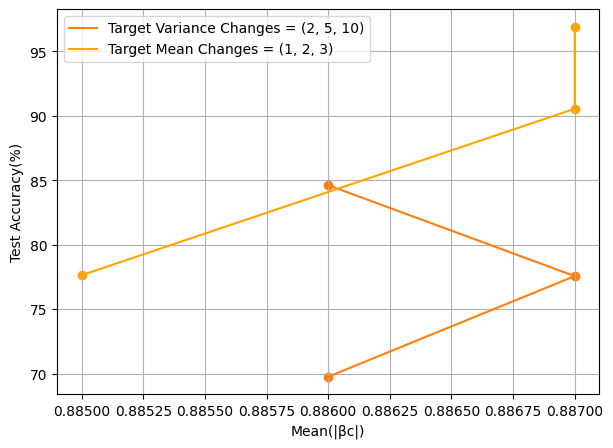

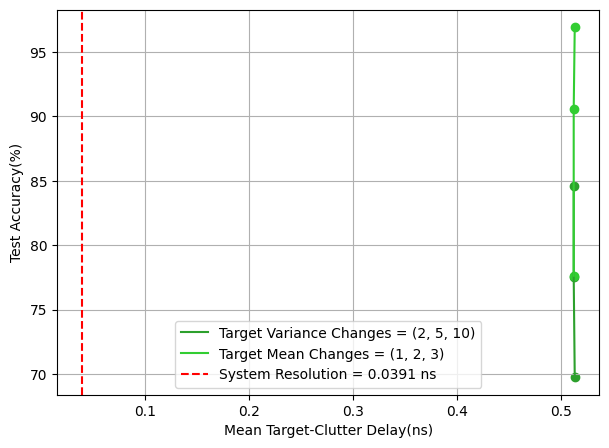

In [40]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

system_resolution = 3.90625e-11  # seconds
system_resolution_ns = round(system_resolution * 1e9, 4)

dataset_names = [
    "m_t=0   var_t=2,   m_c=0   var_c=2",
    "m_t=0   var_t=5,   m_c=0   var_c=2",
    "m_t=0   var_t=10,   m_c=0   var_c=2",
    "m_t=1   var_t=1,   m_c=0   var_c=2",
    "m_t=2   var_t=1,   m_c=0   var_c=2",
    "m_t=3   var_t=1,   m_c=0   var_c=2"
]

dataset_files = [
    "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_trg_v2.pkl",
    "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_trg_v5.pkl",
    "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_trg_v10.pkl",
     "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_trg_m1.pkl",
    "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_trg_m2.pkl",
    "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_trg_m3.pkl"
]

# Prepare lists for summary
summary_data = []

for idx, file in enumerate(dataset_files):
    with open(file, 'rb') as f:
        data = pickle.load(f)






    accs = [69.75, 77.56, 84.62, 77.63, 90.55, 96.92]
    delays = []
    b0_mags_all = []
    bc_mags_all = []

    for (yl2, xl2, v, tau, min_dist, min_delay_sec, b0_mag, bc_mags) in data:
        delays.append(min_delay_sec)
        if isinstance(b0_mag, np.ndarray):
            b0_mags_all.extend(b0_mag.flatten())
        elif b0_mag is not None:
            b0_mags_all.append(b0_mag)

        bc_mags_all.extend(np.abs(bc_mags))

    mean_b0 = np.mean(b0_mags_all)
    mean_bc = np.mean(bc_mags_all)
    mean_delay_ns = np.mean(delays)


    test_accuracy = accs[idx]

    summary_data.append({
        "Dataset": dataset_names[idx],
        "Mean(|β₀|)": round(mean_b0, 3),
        "Mean(|βc|)": round(mean_bc, 3),
        "Mean Delay (ns)": round(mean_delay_ns, 3),
        "Test Accuracy (%)": round(test_accuracy, 2)
    })

# Create DataFrame
df2 = pd.DataFrame(summary_data)
print(df2)

# Plotting Accuracy vs β₀
plt.figure(figsize=(7, 5))
plt.scatter(df2["Mean(|β₀|)"][0:3], df2["Test Accuracy (%)"][0:3], color='royalblue')
plt.plot(df2["Mean(|β₀|)"][0:3], df2["Test Accuracy (%)"][0:3], color='royalblue', label=f"Target Variance Changes = {2, 5, 10}")
plt.scatter(df2["Mean(|β₀|)"][3:], df2["Test Accuracy (%)"][3:], color='skyblue')
plt.plot(df2["Mean(|β₀|)"][3:], df2["Test Accuracy (%)"][3:], color='skyblue', label=f"Target Mean Changes = {1, 2, 3}")
plt.xlabel("Mean(|β₀|)")
plt.ylabel("Test Accuracy(%)")
plt.legend()
# plt.title("Accuracy vs. Target Strength (|β₀|)")
plt.grid(True)
plt.show()

# Plotting Accuracy vs βc
plt.figure(figsize=(7, 5))
plt.scatter(df2["Mean(|βc|)"][0:3], df2["Test Accuracy (%)"][0:3], color='#ff7f0e')
plt.plot(df2["Mean(|βc|)"][0:3], df2["Test Accuracy (%)"][0:3], color='#ff7f0e', label=f"Target Variance Changes = {2, 5, 10}")
plt.scatter(df2["Mean(|βc|)"][3:], df2["Test Accuracy (%)"][3:], color='orange')
plt.plot(df2["Mean(|βc|)"][3:], df2["Test Accuracy (%)"][3:], color='orange', label=f"Target Mean Changes = {1, 2, 3}")
plt.xlabel("Mean(|βc|)")
plt.ylabel("Test Accuracy(%)")
plt.legend()
# plt.title("Accuracy vs. Clutter Strength (|βc|)")
plt.grid(True)
plt.show()

# Plotting Accuracy vs Delay
plt.figure(figsize=(7, 5))
plt.scatter(df2["Mean Delay (ns)"][0:3], df2["Test Accuracy (%)"][0:3], color='#2ca02c')
plt.plot(df2["Mean Delay (ns)"][0:3], df2["Test Accuracy (%)"][0:3], color='#2ca02c', label=f"Target Variance Changes = {2, 5, 10}")
plt.scatter(df2["Mean Delay (ns)"][3:], df2["Test Accuracy (%)"][3:], color='limegreen')
plt.plot(df2["Mean Delay (ns)"][3:], df2["Test Accuracy (%)"][3:], color='limegreen', label=f"Target Mean Changes = {1, 2, 3}")
plt.axvline(system_resolution_ns, color='red', linestyle='--', label=f"System Resolution = {system_resolution_ns} ns")
plt.xlabel("Mean Target-Clutter Delay(ns)")
plt.ylabel("Test Accuracy(%)")
# plt.title("Accuracy vs. Target-Clutter Delay")
plt.legend()
plt.grid(True)
plt.show()



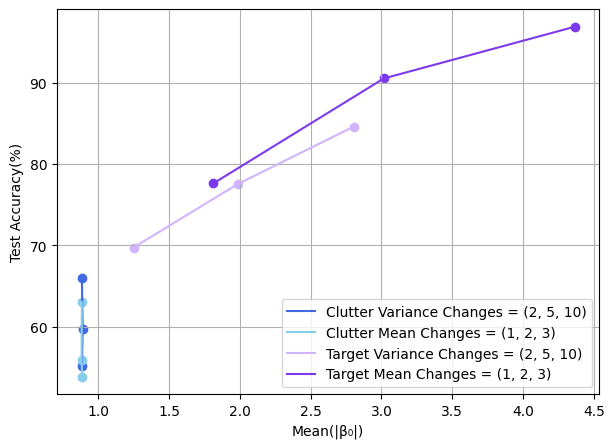

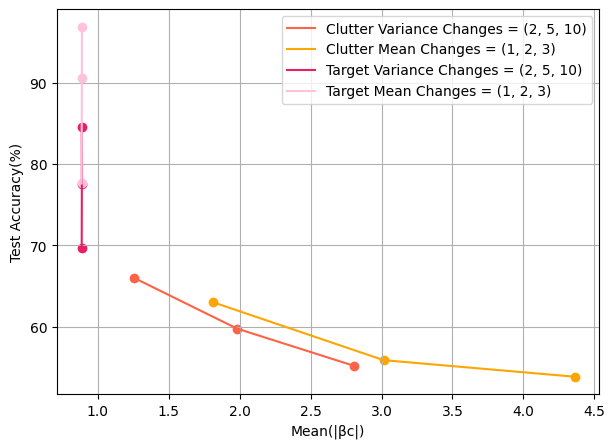

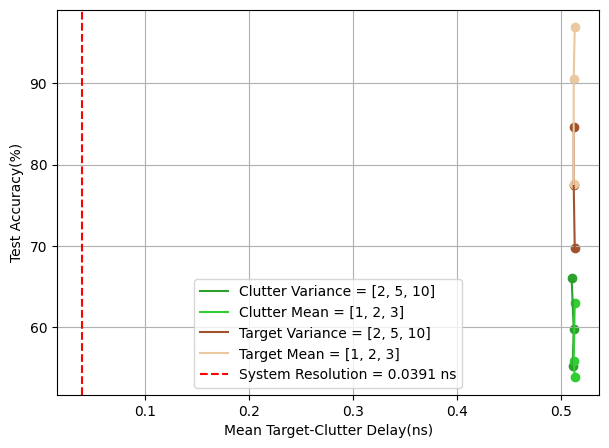

In [9]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# system_resolution = 3.90625e-11  # seconds
# system_resolution_ns = round(system_resolution * 1e9, 4)

# dataset_names = [
#     "m_t=0   var_t=1,   m_c=0   var_c=2",
#     "m_t=0   var_t=1,   m_c=0   var_c=5",
#     "m_t=0   var_t=1,   m_c=0   var_c=10",
#     "m_t=0   var_t=1,   m_c=1   var_c=2",
#     "m_t=0   var_t=1,   m_c=2   var_c=2",
#     "m_t=0   var_t=1,   m_c=3   var_c=2",
#     "m_t=0   var_t=2,   m_c=0   var_c=2",
#     "m_t=0   var_t=5,   m_c=0   var_c=2",
#     "m_t=0   var_t=10,  m_c=0   var_c=2",
#     "m_t=1   var_t=1,   m_c=0   var_c=2",
#     "m_t=2   var_t=1,   m_c=0   var_c=2",
#     "m_t=3   var_t=1,   m_c=0   var_c=2"
# ]

# dataset_files = [
#     "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_clt_v2.pkl",
#     "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_clt_v5.pkl",
#     "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_clt_v10.pkl",
#      "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_clt_m1.pkl",
#     "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_clt_m2.pkl",
#     "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_clt_m3.pkl",
#     "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_trg_v2.pkl",
#     "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_trg_v5.pkl",
#     "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_trg_v10.pkl",
#      "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_trg_m1.pkl",
#     "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_trg_m2.pkl",
#     "/content/drive/MyDrive/Colab Notebooks/SNN/Dataset/clusternew_dt_trg_m3.pkl"
# ]

# # Prepare lists for summary
# summary_data = []

# for idx, file in enumerate(dataset_files):
#     with open(file, 'rb') as f:
#         data = pickle.load(f)

#     accs = [66.03, 59.77, 55.19, 63.01, 55.89, 53.85, 69.75, 77.56, 84.62, 77.63, 90.55, 96.92]
#     delays = []
#     b0_mags_all = []
#     bc_mags_all = []

#     for (yl2, xl2, v, tau, min_dist, min_delay_sec, b0_mag, bc_mags) in data:
#         delays.append(min_delay_sec)
#         if isinstance(b0_mag, np.ndarray):
#             b0_mags_all.extend(b0_mag.flatten())
#         elif b0_mag is not None:
#             b0_mags_all.append(b0_mag)

#         bc_mags_all.extend(np.abs(bc_mags))

#     mean_b0 = np.mean(b0_mags_all)
#     mean_bc = np.mean(bc_mags_all)
#     mean_delay_ns = np.mean(delays)


#     test_accuracy = accs[idx]

#     summary_data.append({
#         "Dataset": dataset_names[idx],
#         "Mean(|β₀|)": round(mean_b0, 3),
#         "Mean(|βc|)": round(mean_bc, 3),
#         "Mean Delay (ns)": round(mean_delay_ns, 3),
#         "Test Accuracy (%)": round(test_accuracy, 2)
#     })

# # Create DataFrame
# df = pd.DataFrame(summary_data)
# print(df)

# Plotting Accuracy vs β₀
plt.figure(figsize=(7, 5))
plt.scatter(df["Mean(|β₀|)"][0:3], df["Test Accuracy (%)"][0:3], color='royalblue')
plt.plot(df["Mean(|β₀|)"][0:3], df["Test Accuracy (%)"][0:3], color='royalblue', label=f"Clutter Variance Changes = {2, 5, 10}")
plt.scatter(df["Mean(|β₀|)"][3:6], df["Test Accuracy (%)"][3:6], color='skyblue')
plt.plot(df["Mean(|β₀|)"][3:6], df["Test Accuracy (%)"][3:6], color='skyblue', label=f"Clutter Mean Changes = {1, 2, 3}")

plt.scatter(df["Mean(|β₀|)"][6:9], df["Test Accuracy (%)"][6:9], color='#d1b3ff')
plt.plot(df["Mean(|β₀|)"][6:9], df["Test Accuracy (%)"][6:9], color='#d1b3ff', label=f"Target Variance Changes = {2, 5, 10}")
plt.scatter(df["Mean(|β₀|)"][9:12], df["Test Accuracy (%)"][9:12], color='#7c3aed')
plt.plot(df["Mean(|β₀|)"][9:12], df["Test Accuracy (%)"][9:12], color='#7c3aed', label=f"Target Mean Changes = {1, 2, 3}")

plt.xlabel("Mean(|β₀|)")
plt.ylabel("Test Accuracy(%)")
plt.legend()
# plt.title("Accuracy vs. Target Strength (|β₀|)")
plt.grid(True)
plt.show()

# Plotting Accuracy vs βc
plt.figure(figsize=(7, 5))
plt.scatter(df["Mean(|βc|)"][0:3], df["Test Accuracy (%)"][0:3], color='Tomato')
plt.plot(df["Mean(|βc|)"][0:3], df["Test Accuracy (%)"][0:3], color='Tomato', label=f"Clutter Variance Changes = {2, 5, 10}")
plt.scatter(df["Mean(|βc|)"][3:6], df["Test Accuracy (%)"][3:6], color='orange')
plt.plot(df["Mean(|βc|)"][3:6], df["Test Accuracy (%)"][3:6], color='orange', label=f"Clutter Mean Changes = {1, 2, 3}")

plt.scatter(df["Mean(|βc|)"][6:9], df["Test Accuracy (%)"][6:9], color='#e91e63')
plt.plot(df["Mean(|βc|)"][6:9], df["Test Accuracy (%)"][6:9], color='#e91e63', label=f"Target Variance Changes = {2, 5, 10}")
plt.scatter(df["Mean(|βc|)"][9:12], df["Test Accuracy (%)"][9:12], color='#ffc1dc')
plt.plot(df["Mean(|βc|)"][9:12], df["Test Accuracy (%)"][9:12], color='#ffc1dc', label=f"Target Mean Changes = {1, 2, 3}")


plt.xlabel("Mean(|βc|)")
plt.ylabel("Test Accuracy(%)")
plt.legend()
# plt.title("Accuracy vs. Clutter Strength (|βc|)")
plt.grid(True)
plt.show()

# Plotting Accuracy vs Delay
plt.figure(figsize=(7, 5))
plt.scatter(df["Mean Delay (ns)"][0:3], df["Test Accuracy (%)"][0:3], color='#2ca02c')
plt.plot(df["Mean Delay (ns)"][0:3], df["Test Accuracy (%)"][0:3], color='#2ca02c', label=f"Clutter Variance = {[2, 5, 10]}")
plt.scatter(df["Mean Delay (ns)"][3:6], df["Test Accuracy (%)"][3:6], color='limegreen')
plt.plot(df["Mean Delay (ns)"][3:6], df["Test Accuracy (%)"][3:6], color='limegreen', label=f"Clutter Mean = {[1, 2, 3]}")

plt.scatter(df["Mean Delay (ns)"][6:9], df["Test Accuracy (%)"][6:9], color='#a0522d')
plt.plot(df["Mean Delay (ns)"][6:9], df["Test Accuracy (%)"][6:9], color='#a0522d', label=f"Target Variance = {[2, 5, 10]}")
plt.scatter(df["Mean Delay (ns)"][9:12], df["Test Accuracy (%)"][9:12], color='#eac9a1')
plt.plot(df["Mean Delay (ns)"][9:12], df["Test Accuracy (%)"][9:12], color='#eac9a1', label=f"Target Mean = {[1, 2, 3]}")


plt.axvline(system_resolution_ns, color='red', linestyle='--', label=f"System Resolution = {system_resolution_ns} ns")
plt.xlabel("Mean Target-Clutter Delay(ns)")
plt.ylabel("Test Accuracy(%)")
# plt.title("Accuracy vs. Target-Clutter Delay")
plt.legend()
plt.grid(True)
plt.show()


**Add a extra hidden layer in Network structure**

In [ ]:
from snntorch import surrogate

#layer parameters
Ny=32
Nx=32
num_inputs = 16
num_hidden = 256
num_output = 1
num_steps = 80
beta = 0.95
batch_size = 128
dtype = torch.float

#define network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function

        # initialize additional layers for y and x inputs
        self.fc_y = nn.Linear(num_inputs, Ny)
        self.lif_y = snn.Leaky(beta = beta)
        self.fc_x = nn.Linear(num_inputs, Nx)
        self.lif_x = snn.Leaky(beta = beta)

        # initialize SNN layers
        # self.fc1 = nn.Linear(Ny + Nx, num_hidden)
        # self.lif1 = snn.Leaky(beta = beta)
        self.fc1 = nn.Linear(Ny + Nx, 512)
        self.lif1 = snn.Leaky(beta=beta)
        #------------------------------------
        self.fc12 = nn.Linear(512, num_hidden)
        self.lif12 = snn.Leaky(beta=beta)
        #------------------------------------

        # Classification Branch v
        self.fc2 = nn.Linear(num_hidden, num_output)
        self.lif2 = snn.Leaky(beta = beta)

        # Regression Branch τ
        beta_out = torch.rand(1) # randomly initialize decay rate for output neuron
        self.fc_reg = nn.Linear(num_hidden, num_output)
        self.li_out = snn.Leaky(beta=beta, threshold=1.0, learn_beta=True, spike_grad=spike_grad, reset_mechanism="none") #Note the reset mechanism is disabled and we will disregard output spikes.

        # No activation function for τ prediction


    def forward(self, y, x):

        # initialize hidden states at t=0
        mem_y = self.lif_y.init_leaky()
        mem_x = self.lif_x.init_leaky()
        mem1 = self.lif1.init_leaky()
        #------------------------------------
        mem12 = self.lif12.init_leaky()
        #------------------------------------
        mem2 = self.lif2.init_leaky()
        mem_reg = self.li_out.init_leaky()

        mem2_rec = []
        spk2_rec = []
        tau_rec = []

        for step in range(num_steps):                         #Loop over 80 time steps
            cur_y = self.fc_y(y[step])
            spk_y, mem_y = self.lif_y(cur_y, mem_y)
            cur_x = self.fc_x(x[step])
            spk_x, mem_x = self.lif_x(cur_x, mem_x)

            combined_input = torch.cat((spk_y, spk_x), dim=1) #Shape:[batch_size:128, Ny + Nx:64]

            cur1 = self.fc1(combined_input)
            spk1, mem1 = self.lif1(cur1, mem1)                #torch.Size([128, 256])
            #------------------------------------
            cur12 = self.fc12(spk1)
            spk12, mem12 = self.lif12(cur12, mem12)
            #------------------------------------

            # Classification branch
            cur2 = self.fc2(spk12) #(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)                #torch.Size([128, 1])
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

            # Regression branch
            cur_reg = self.fc_reg(spk1)
            _, mem_reg = self.li_out(cur_reg, mem_reg)
            tau_rec.append(mem_reg)

        return (torch.stack(spk2_rec, dim=0),
                torch.stack(mem2_rec, dim=0),
                torch.stack(tau_rec, dim=0)) #[num_steps:80, batch_size:128, 1]

# Load the network onto CUDA if available
net = Net().to(device)
